# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


In [7]:
from matplotlib import pyplot
def inverse_plot_colorscheme():
    import cycler
    def invert(color_to_convert): 
        table = str.maketrans('0123456789abcdef', 'fedcba9876543210')
        return '#' + color_to_convert[1:].lower().translate(table).upper()
    update_dict = {}
    for key, value in pyplot.rcParams.items():
        if value == 'black':
            update_dict[key] = 'white'
        elif value == 'white':
            update_dict[key] = 'black'
    
    old_cycle = pyplot.rcParams['axes.prop_cycle']
    new_cycle = []
    for value in old_cycle:
        new_cycle.append({
            'color': invert(value['color'])
        })
    pyplot.rcParams.update(update_dict)
    pyplot.rcParams['axes.prop_cycle'] = cycler.Cycler(new_cycle)
    lec = pyplot.rcParams['legend.edgecolor']
    lec = str(1 - float(lec))
    pyplot.rcParams['legend.edgecolor'] = lec

In [8]:
inverse_plot_colorscheme()

Train the `KNeighborsClassifier` on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression

#Загружаем данные
digits = pd.read_csv('forest_dataset.csv')
X, y = digits[digits.columns[:-1]].values, digits[digits.columns[-1]].values


#Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [3]:
#Создаем классификатор
clf = KNeighborsClassifier()

#Определяем параметры для GridSearchCV
params = {
    'n_neighbors': list(range(1, 11)),  #количество соседей от 1 до 10
    'metric': ['manhattan', 'euclidean'],  #метрики расстояний
    'weights': ['uniform', 'distance']  #веса соседей
}

#Создаем GridSearchCV
clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(X_train, y_train)

#Выводим лучшие параметры
print("Лучшие параметры:", clf_grid.best_params_)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


Let's output the best parameters

In [4]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

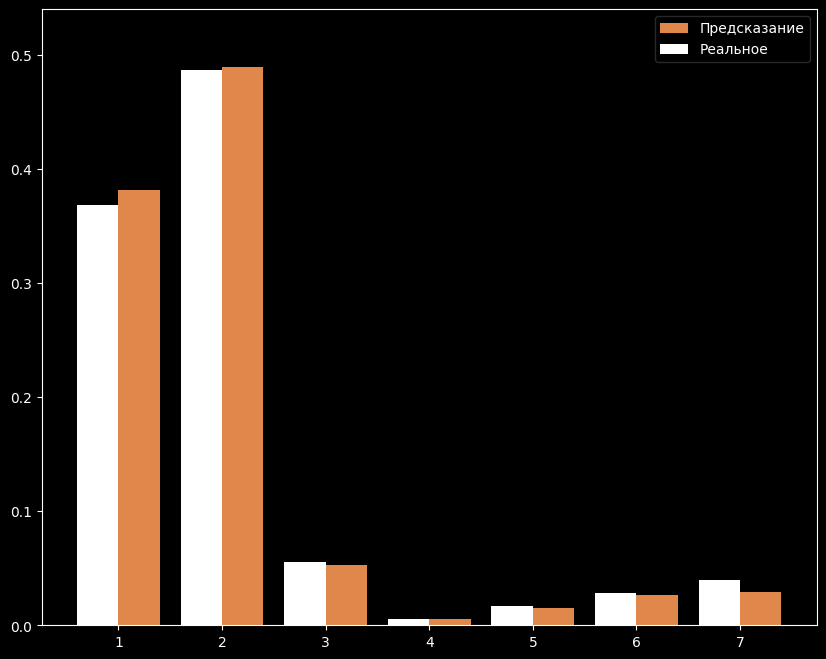

In [22]:
#Обучаем KNN с оптимальными параметрами
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(X_train, y_train)

#Делаем предсказания вероятностей
pred_prob = optimal_clf.predict_proba(X_test)
#Вычисляем частоту классов в реальной выборке
unique, freq = np.unique(y_test, return_counts=True)
freq = list(map(lambda x: x / len(y_test), freq))

#Вычисляем частоту классов в предсказаниях
pred_freq = pred_prob.mean(axis=0)
x_grid = np.arange(1,8)

#Строим гистограмму
plt.figure(figsize=(10, 8))
plt.bar(x_grid, pred_freq, width=0.4, align="edge", label='Предсказание')
plt.bar(x_grid, freq, width=-0.4, align="edge", label='Реальное', color = 'white')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [23]:
#Обучаем логистическую регрессию
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

#Предсказываем метки классов
y_pred_knn = optimal_clf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

#Оцениваем точность
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f'Точность KNN: {accuracy_knn:.4f}')
print(f'Точность логистической регрессии: {accuracy_log_reg:.4f}')

c:\Users\Юзер\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Точность KNN: 0.7845
Точность логистической регрессии: 0.6985


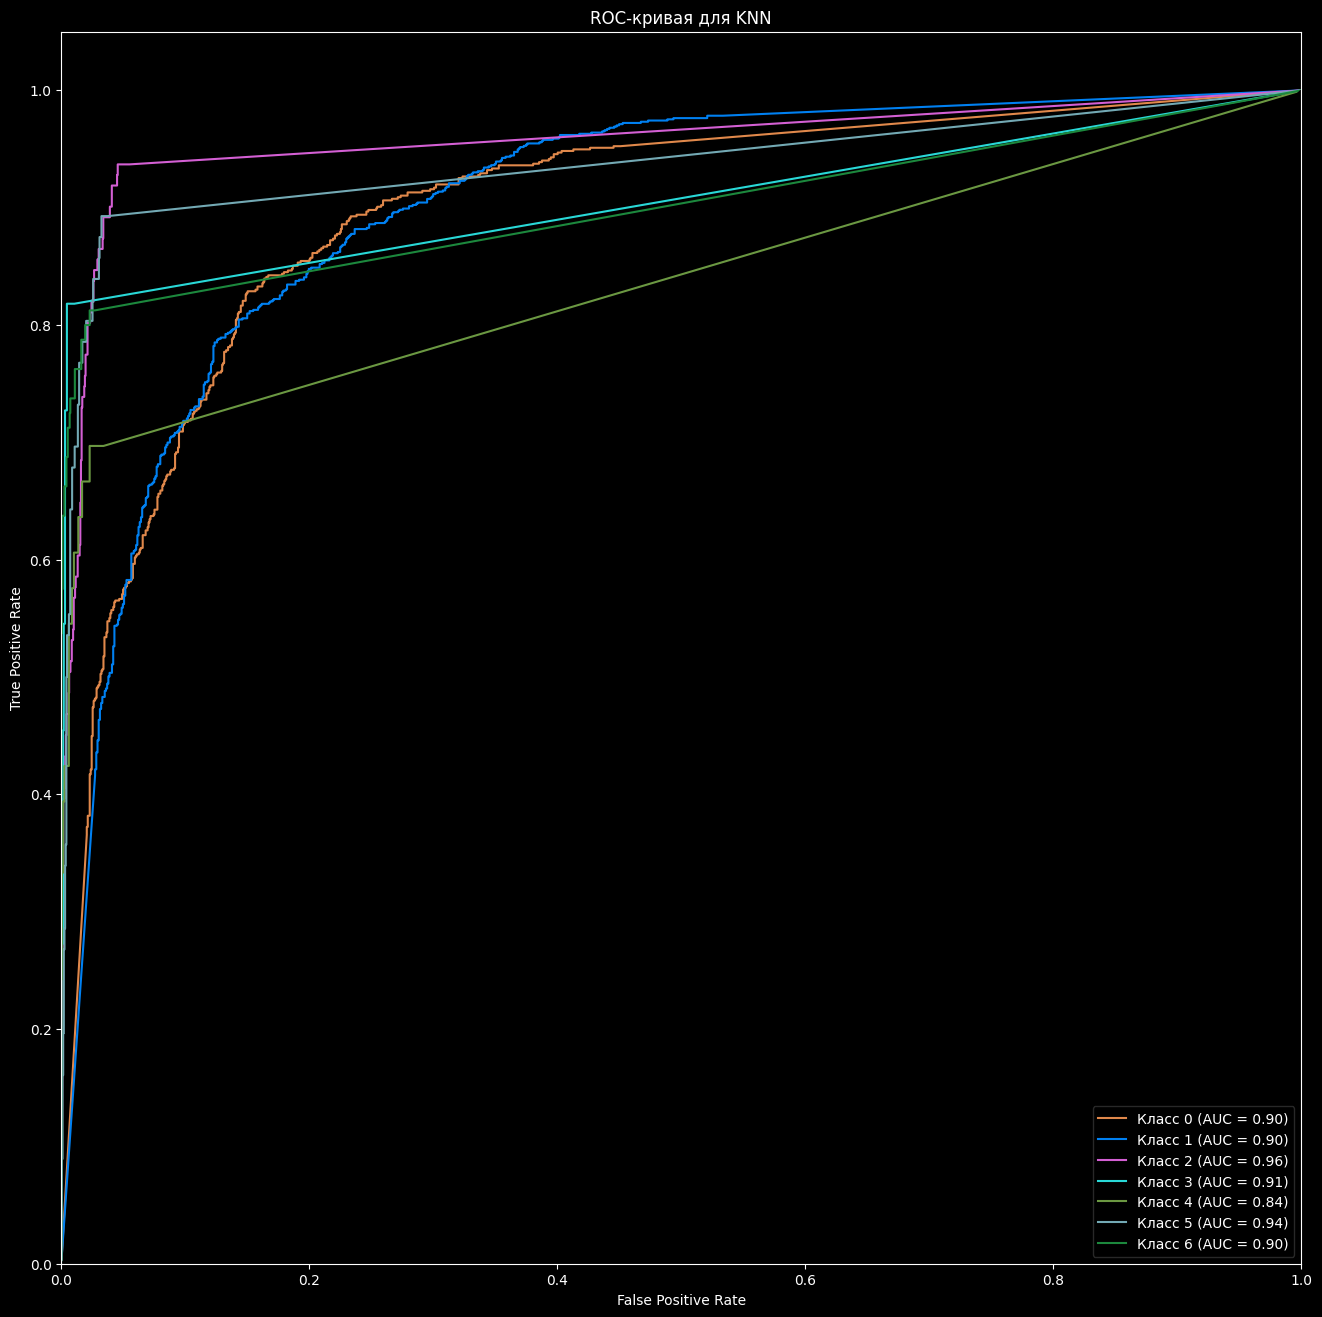

Среднее значение AUC (AUC-ROC): 0.91


In [25]:
# Бинаризуем классы для ROC-AUC анализа
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Строим ROC-кривую
plt.figure(figsize=(16, 16))

# Список для хранения значений AUC для каждого класса
roc_auc_values = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], pred_prob[:, i])  # Получаем FPR и TPR
    roc_auc = auc(fpr, tpr)  # Вычисляем AUC для этого класса
    roc_auc_values.append(roc_auc)  # Сохраняем AUC
    
    # Строим ROC-кривую для каждого класса с отображением AUC в легенде
    plt.plot(fpr, tpr, label=f'Класс {i} (AUC = {roc_auc:.2f})')

# Добавляем диагональ для случайной модели
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для KNN')
plt.legend(loc="lower right")
plt.show()

# Рассчитываем и выводим среднее значение AUC (AUC-ROC)
mean_auc = np.mean(roc_auc_values)
print(f'Среднее значение AUC (AUC-ROC): {mean_auc:.2f}')

В данном случае логистическая регрессия сработала хуже, значит в данных есть нелинейные зависимости

Плюсы(kNN):
Простой и интуитивно понятный алгоритм.
Хорошо работает при наличии нелинейных зависимостей в данных.
Не требует обучения модели, лишь хранит данные.
Минусы(kNN):
Высокая вычислительная сложность (поиск соседей требует времени).
Чувствителен к выбору метрики расстояний и количества соседей.
Может плохо работать на многомерных данных.
Вывод по ROC-кривой и AUC-ROC:
Чем выше площадь под ROC-кривой (AUC), тем лучше классификатор.
В данном случае AUC показывает качество KNN при разных порогах вероятности.
Если AUC ближе к 1, значит модель хорошо отделяет классы. Если AUC ≈ 0.5, то модель случайная.